## SMILe Logistics Innovation Hack: Data Dive

### Dataset Source

The dataset for this project was sourced from Kaggle and can be found [here](https://www.kaggle.com/datasets/harshsingh2209/supply-chain-analysis/data). The dataset provides detailed information on various aspects of supply chain management, including product information, sales, logistics, and costs.

### Project Objective

The main objective of this project is to create a predictive model to estimate the shipping costs. The model should consider various factors such as lead times, transportation modes, stock levels, and more.

### Code Explanation

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Sklearn Libraries for Preprocessing, Model Building, and Evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# XGBoost Library
import xgboost as xgb

In [2]:
# Load the original dataset
original_df = pd.read_csv('supply_chain_data.csv')

In [3]:
# Display the shape of the original dataset
original_df.shape

(100, 24)

### Generating Synthetic Data Using GANs

This code generates synthetic data using a Generative Adversarial Network (GAN). The GAN consists of a Generator and a Discriminator that work together to produce realistic synthetic data.

### Key Steps

1. **Load and Preprocess Data**
    - Load dataset and identify categorical and numerical columns.
    - Encode categorical variables and normalize numerical features.

2. **Define Models**
    - **Generator**: Creates synthetic data.
    - **Discriminator**: Distinguishes between real and synthetic data.

3. **Train the GAN**
    - Alternately train the Discriminator and Generator.
    - Discriminator learns to distinguish real data from synthetic data.
    - Generator learns to create data that fools the Discriminator.

4. **Generate and Save Synthetic Data**
    - Generate synthetic data using the trained Generator.
    - Inverse transform and decode categorical variables.
    - Save the synthetic data to a CSV file.

### Code

```python
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load and preprocess data
file_path = 'supply_chain_data.csv'
df = pd.read_csv(file_path)
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns

label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_columns}
for col, le in label_encoders.items():
    df[col] = le.transform(df[col])

features = df.values
target = df['Shipping costs'].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

# Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_dim = features_scaled.shape[1]
gen = Generator(input_dim, input_dim)
disc = Discriminator(input_dim)
criterion = nn.BCELoss()
optimizer_gen = optim.Adam(gen.parameters(), lr=0.001)
optimizer_disc = optim.Adam(disc.parameters(), lr=0.001)

# Train the GAN
num_epochs = 1000
batch_size = 16
for epoch in range(num_epochs):
    for i in range(0, len(features_tensor), batch_size):
        real_data = features_tensor[i:i+batch_size]
        batch_size_actual = real_data.size(0)
        
        # Train Discriminator
        optimizer_disc.zero_grad()
        real_labels = torch.ones(batch_size_actual, 1)
        fake_labels = torch.zeros(batch_size_actual, 1)
        outputs_real = disc(real_data)
        loss_real = criterion(outputs_real, real_labels)
        noise = torch.randn(batch_size_actual, input_dim)
        fake_data = gen(noise)
        outputs_fake = disc(fake_data.detach())
        loss_fake = criterion(outputs_fake, fake_labels)
        loss_disc = loss_real + loss_fake
        loss_disc.backward()
        optimizer_disc.step()
        
        # Train Generator
        optimizer_gen.zero_grad()
        outputs = disc(fake_data)
        loss_gen = criterion(outputs, real_labels)
        loss_gen.backward()
        optimizer_gen.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}')

# Generate and save synthetic data
num_synthetic_rows = 1000
noise = torch.randn(num_synthetic_rows, input_dim)
synthetic_data = gen(noise).detach().numpy()
synthetic_data = scaler.inverse_transform(synthetic_data)

synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
for col, le in label_encoders.items():
    col_index = synthetic_df.columns.get_loc(col)
    synthetic_df.iloc[:, col_index] = np.round(synthetic_df.iloc[:, col_index]).astype(int)
    synthetic_df.iloc[:, col_index] = np.clip(synthetic_df.iloc[:, col_index], 0, len(le.classes_) - 1)
    synthetic_df.iloc[:, col_index] = le.inverse_transform(synthetic_df.iloc[:, col_index].astype(int))

synthetic_df.to_csv('synthetic_supply_chain_data.csv', index=False)
print("Synthetic rows generation complete and saved to 'synthetic_supply_chain_data.csv'.")
```


### Combining and Preprocessing Data

After generating synthetic data, we combine it with the original dataset and preprocess it for further analysis.

In [4]:
# Load the synthetic dataset
synthetic_df = pd.read_csv('synthetic_supply_chain_data.csv')

# Combine both datasets
df = pd.concat([original_df, synthetic_df], ignore_index=True)

# Display the shape of the combined dataset
df.shape

(1100, 24)

In [5]:
# Check for missing values
df.isnull().sum()

Product type               0
SKU                        0
Price                      0
Availability               0
Number of products sold    0
Revenue generated          0
Customer demographics      0
Stock levels               0
Lead times                 0
Order quantities           0
Shipping times             0
Shipping carriers          0
Shipping costs             0
Supplier name              0
Location                   0
Lead time                  0
Production volumes         0
Manufacturing lead time    0
Manufacturing costs        0
Inspection results         0
Defect rates               0
Transportation modes       0
Routes                     0
Costs                      0
dtype: int64

In [6]:
# Display the first few rows of the dataframe
df.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55.0,802.0,8661.996792,Non-binary,58.0,7.0,96.0,...,Mumbai,29.0,215.0,29.0,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95.0,736.0,7460.900065,Female,53.0,30.0,37.0,...,Mumbai,23.0,517.0,30.0,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34.0,8.0,9577.749626,Unknown,1.0,10.0,88.0,...,Mumbai,12.0,971.0,27.0,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68.0,83.0,7766.836426,Non-binary,23.0,13.0,59.0,...,Kolkata,24.0,937.0,18.0,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26.0,871.0,2686.505152,Non-binary,5.0,3.0,56.0,...,Delhi,5.0,414.0,3.0,92.065161,Fail,3.145580,Air,Route A,923.440632


In [7]:
# Display information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             1100 non-null   object 
 1   SKU                      1100 non-null   object 
 2   Price                    1100 non-null   float64
 3   Availability             1100 non-null   float64
 4   Number of products sold  1100 non-null   float64
 5   Revenue generated        1100 non-null   float64
 6   Customer demographics    1100 non-null   object 
 7   Stock levels             1100 non-null   float64
 8   Lead times               1100 non-null   float64
 9   Order quantities         1100 non-null   float64
 10  Shipping times           1100 non-null   float64
 11  Shipping carriers        1100 non-null   object 
 12  Shipping costs           1100 non-null   float64
 13  Supplier name            1100 non-null   object 
 14  Location                

In [8]:
# Getting the shape of the DataFrame
df.shape

(1100, 24)

### Data Preprocessing

We need to preprocess the combined dataset to make it suitable for machine learning models.

In [9]:
# Drop the SKU column as it is used only for uniquely identifying the rows
df = df.drop(columns=['SKU'])

In [10]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# List of categorical columns to label encode
categorical_columns_label = [
    'Product type', 'Customer demographics', 'Shipping carriers', 
    'Supplier name', 'Location', 'Inspection results', 
    'Transportation modes', 'Routes'
]

# Apply label encoding to each of the categorical columns
for column in categorical_columns_label:
    df[column] = label_encoder.fit_transform(df[column])

In [11]:
# Display the label encoded dataframe
df.head()

,Product type,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,Shipping times,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,1,69.808006,55.0,802.0,8661.996792,2,58.0,7.0,96.0,4.0,...,4,29.0,215.0,29.0,46.279879,2,0.226410,2,1,187.752075
1,2,14.843523,95.0,736.0,7460.900065,0,53.0,30.0,37.0,2.0,...,4,23.0,517.0,30.0,33.616769,2,4.854068,2,1,503.065579
2,1,11.319683,34.0,8.0,9577.749626,3,1.0,10.0,88.0,2.0,...,4,12.0,971.0,27.0,30.688019,2,4.580593,0,2,141.920282
3,2,61.163343,68.0,83.0,7766.836426,2,23.0,13.0,59.0,6.0,...,3,24.0,937.0,18.0,35.624741,0,4.746649,1,0,254.776159
4,2,4.805496,26.0,871.0,2686.505152,2,5.0,3.0,56.0,8.0,...,2,5.0,414.0,3.0,92.065161,0,3.145580,0,0,923.440632


In [12]:
# Display information about the encoded dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             1100 non-null   int64  
 1   Price                    1100 non-null   float64
 2   Availability             1100 non-null   float64
 3   Number of products sold  1100 non-null   float64
 4   Revenue generated        1100 non-null   float64
 5   Customer demographics    1100 non-null   int64  
 6   Stock levels             1100 non-null   float64
 7   Lead times               1100 non-null   float64
 8   Order quantities         1100 non-null   float64
 9   Shipping times           1100 non-null   float64
 10  Shipping carriers        1100 non-null   int64  
 11  Shipping costs           1100 non-null   float64
 12  Supplier name            1100 non-null   int64  
 13  Location                 1100 non-null   int64  
 14  Lead time               

In [13]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Display the count of missing values in each column
print("Count of missing values in each column:")
print(missing_values)

Count of missing values in each column:
Product type               0
Price                      0
Availability               0
Number of products sold    0
Revenue generated          0
Customer demographics      0
Stock levels               0
Lead times                 0
Order quantities           0
Shipping times             0
Shipping carriers          0
Shipping costs             0
Supplier name              0
Location                   0
Lead time                  0
Production volumes         0
Manufacturing lead time    0
Manufacturing costs        0
Inspection results         0
Defect rates               0
Transportation modes       0
Routes                     0
Costs                      0
dtype: int64


### Handling Outliers

To ensure the data quality, we need to handle outliers in the dataset.

In [14]:
# Function to find the number of outliers using the IQR method
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

# Apply the function to each numeric column
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
outliers_count = {col: count_outliers(df[col]) for col in numeric_columns}

# Display the number of outliers in each numeric column
print("Number of outliers in each numeric column:")
for column, count in outliers_count.items():
    print(f"{column}: {count}")

Number of outliers in each numeric column:
Product type: 0
Price: 104
Availability: 132
Number of products sold: 37
Revenue generated: 39
Customer demographics: 0
Stock levels: 22
Lead times: 59
Order quantities: 40
Shipping times: 72
Shipping carriers: 0
Shipping costs: 61
Supplier name: 58
Location: 0
Lead time: 33
Production volumes: 65
Manufacturing lead time: 106
Manufacturing costs: 57
Inspection results: 250
Defect rates: 17
Transportation modes: 0
Routes: 148
Costs: 32


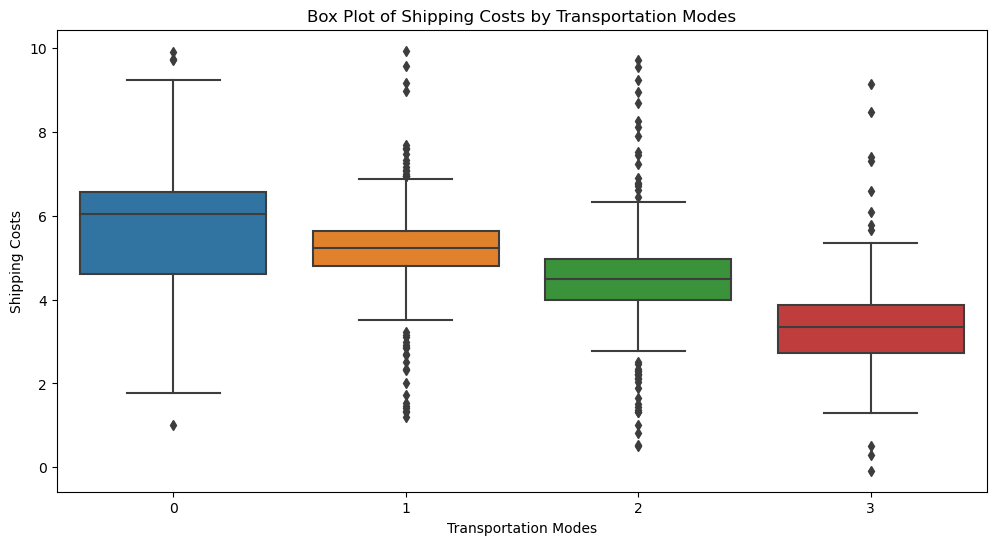

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Transportation modes', y='Shipping costs')
plt.title('Box Plot of Shipping Costs by Transportation Modes')
plt.xlabel('Transportation Modes')
plt.ylabel('Shipping Costs')
plt.show()

In [16]:
# Define a function to cap outliers in a specified column of a DataFrame
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.10)
    Q3 = df[column].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

# Loop through all numeric columns in the DataFrame to cap outliers
for col in numeric_columns:
    df = cap_outliers(df, col)

In [17]:
# Apply the function to each numeric column
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
outliers_count = {col: count_outliers(df[col]) for col in numeric_columns}

# Display the number of outliers in each numeric column
print("Number of outliers in each numeric column:")
for column, count in outliers_count.items():
    print(f"{column}: {count}")

Number of outliers in each numeric column:
Product type: 0
Price: 104
Availability: 132
Number of products sold: 37
Revenue generated: 39
Customer demographics: 0
Stock levels: 22
Lead times: 59
Order quantities: 40
Shipping times: 72
Shipping carriers: 0
Shipping costs: 61
Supplier name: 58
Location: 0
Lead time: 33
Production volumes: 65
Manufacturing lead time: 106
Manufacturing costs: 57
Inspection results: 250
Defect rates: 17
Transportation modes: 0
Routes: 148
Costs: 32


In [18]:
# Display the first few rows of the dataframe
df.head()

,Product type,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,Shipping times,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,1,69.808006,55.0,802.0,8661.996792,2,58.0,7.0,96.0,4.0,...,4,29.0,215.0,29.0,46.279879,2,0.226410,2,1,187.752075
1,2,14.843523,95.0,736.0,7460.900065,0,53.0,30.0,37.0,2.0,...,4,23.0,517.0,30.0,33.616769,2,4.854068,2,1,503.065579
2,1,11.319683,34.0,8.0,9577.749626,3,1.0,10.0,88.0,2.0,...,4,12.0,971.0,27.0,30.688019,2,4.580593,0,2,141.920282
3,2,61.163343,68.0,83.0,7766.836426,2,23.0,13.0,59.0,6.0,...,3,24.0,937.0,18.0,35.624741,0,4.746649,1,0,254.776159
4,2,4.805496,26.0,871.0,2686.505152,2,5.0,3.0,56.0,8.0,...,2,5.0,414.0,3.0,92.065161,0,3.145580,0,0,923.440632


### Data Visualization

We will visualize the distribution of the shipping costs before and after adding synthetic data.

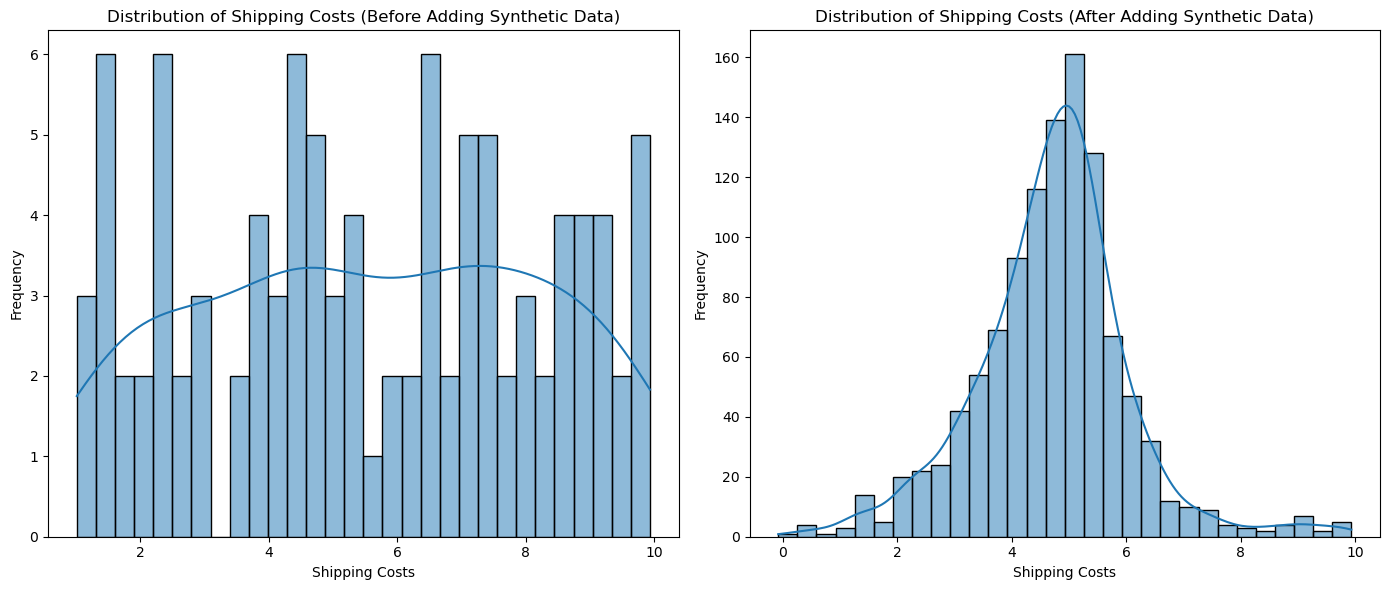

In [19]:
# Assuming original_df is the original DataFrame before adding synthetic data
# Assuming df is the DataFrame after adding synthetic data

plt.figure(figsize=(14, 6))

# Histogram for original data
plt.subplot(1, 2, 1)
sns.histplot(original_df['Shipping costs'], kde=True, bins=30)
plt.title('Distribution of Shipping Costs (Before Adding Synthetic Data)')
plt.xlabel('Shipping Costs')
plt.ylabel('Frequency')

# Histogram for data after adding synthetic rows
plt.subplot(1, 2, 2)
sns.histplot(df['Shipping costs'], kde=True, bins=30)
plt.title('Distribution of Shipping Costs (After Adding Synthetic Data)')
plt.xlabel('Shipping Costs')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Feature Selection

We will identify the most correlated features with 'Shipping costs' and use them for our model.

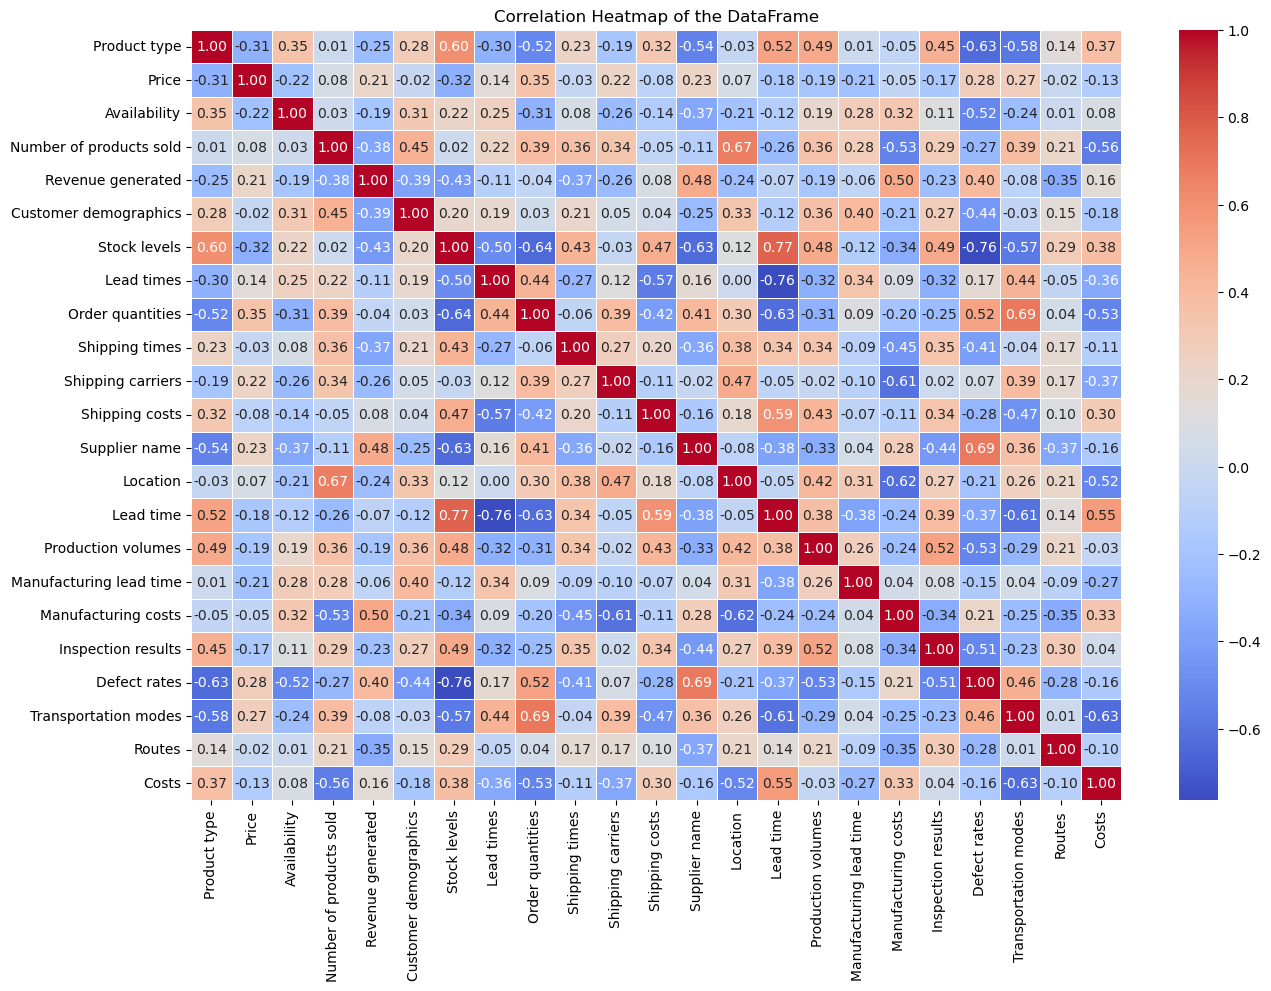

In [20]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of the DataFrame')
plt.show()

In [21]:
# Compute the correlation between 'Shipping costs' and other columns
shipping_costs_corr = correlation_matrix['Shipping costs'].abs().sort_values(ascending=False)

# Exclude the correlation of 'Shipping costs' with itself
shipping_costs_corr = shipping_costs_corr[shipping_costs_corr.index != 'Shipping costs']

# Display the correlation values
print("Correlation between 'Shipping costs' and other feature columns in absolute descending order:")
print(shipping_costs_corr)

Correlation between 'Shipping costs' and other feature columns in absolute descending order:
Lead time                  0.588565
Lead times                 0.568424
Transportation modes       0.471212
Stock levels               0.469592
Production volumes         0.425392
Order quantities           0.418985
Inspection results         0.339432
Product type               0.319381
Costs                      0.296066
Defect rates               0.282140
Shipping times             0.202673
Location                   0.183750
Supplier name              0.160957
Availability               0.136635
Manufacturing costs        0.111734
Shipping carriers          0.110577
Routes                     0.100915
Revenue generated          0.078237
Price                      0.077515
Manufacturing lead time    0.073116
Number of products sold    0.054433
Customer demographics      0.039565
Name: Shipping costs, dtype: float64


### Dimensionality Reduction using PCA

We will apply Principal Component Analysis (PCA) to reduce the dimensionality of our feature set.

In [22]:
# Separating out the features
features = df.drop(columns=['Shipping costs'])  # Assuming 'Shipping costs' is the target column
# Separating out the target
target = df['Shipping costs']

In [23]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [24]:
# Applying PCA
pca = PCA(n_components=15)  # Visualizing the first two principal components
principal_components = pca.fit_transform(scaled_features)

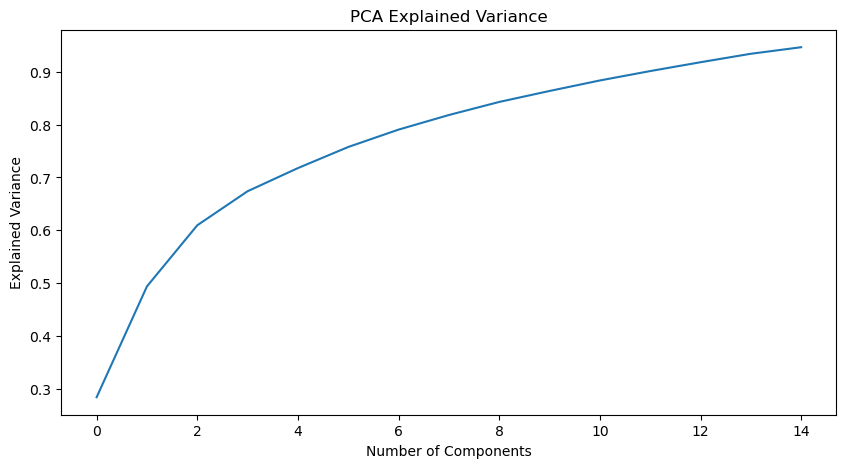

In [25]:
# PCA Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

### Model Training and Evaluation

We will use Recursive Feature Elimination (RFE) and train a stacking regressor with SVR, KNN, and XGBoost as base models, and Ridge regression as the meta-model.

In [26]:
# Using RFE with LinearRegression
linear_reg = LinearRegression()
rfe = RFE(estimator=linear_reg, n_features_to_select=15)
X_rfe = rfe.fit_transform(principal_components, target)

# Print selected features
selected_features = rfe.get_support(indices=True)
print("Selected features:", selected_features)

Selected features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


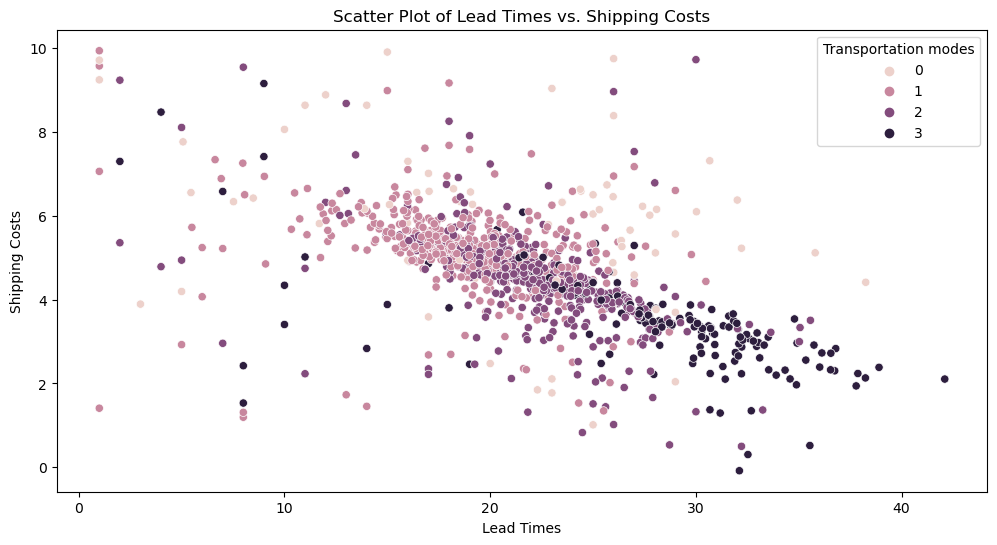

In [27]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Lead times', y='Shipping costs', hue='Transportation modes')
plt.title('Scatter Plot of Lead Times vs. Shipping Costs')
plt.xlabel('Lead Times')
plt.ylabel('Shipping Costs')
plt.show()

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rfe, target, test_size=0.3, random_state=42)

In [29]:
# Train the Linear Regression model
linear_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1.0314739920223224
R-squared: 0.43426567534774885


In [30]:
from sklearn.svm import SVR

svr_reg = SVR()
svr_reg.fit(X_train, y_train)
y_pred_svr = svr_reg.predict(X_test)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Support Vector Regressor - Mean Squared Error:", mse_svr)
print("Support Vector Regressor - R-squared:", r2_svr)

Support Vector Regressor - Mean Squared Error: 0.7236648444996624
Support Vector Regressor - R-squared: 0.6030902909389761


In [31]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)
y_pred_knn = knn_reg.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("K-Nearest Neighbors - Mean Squared Error:", mse_knn)
print("K-Nearest Neighbors - R-squared:", r2_knn)

K-Nearest Neighbors - Mean Squared Error: 0.7789415243498992
K-Nearest Neighbors - R-squared: 0.5727725947236986


In [32]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - Mean Squared Error:", mse_xgb)
print("XGBoost - R-squared:", r2_xgb)

XGBoost - Mean Squared Error: 0.809912400507096
XGBoost - R-squared: 0.5557859447042175


In [33]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

# Initialize the SVR model
svr = SVR()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the model with the best parameters
svr_best = SVR(**best_params)
svr_best.fit(X_train, y_train)
y_pred_svr_best = svr_best.predict(X_test)

mse_svr_best = mean_squared_error(y_test, y_pred_svr_best)
r2_svr_best = r2_score(y_test, y_pred_svr_best)

print("Tuned SVR - Mean Squared Error:", mse_svr_best)
print("Tuned SVR - R-squared:", r2_svr_best)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Parameters: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Score: 0.5027954165108705
Tuned SVR - Mean Squared Error: 0.7430262256115925
Tuned SVR - R-squared: 0.5924711207491227


In [34]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

# Initialize the KNeighborsRegressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the model with the best parameters
knn_best = KNeighborsRegressor(**best_params)
knn_best.fit(X_train, y_train)
y_pred_knn_best = knn_best.predict(X_test)

mse_knn_best = mean_squared_error(y_test, y_pred_knn_best)
r2_knn_best = r2_score(y_test, y_pred_knn_best)

print("Tuned K-Nearest Neighbors - Mean Squared Error:", mse_knn_best)
print("Tuned K-Nearest Neighbors - R-squared:", r2_knn_best)

Fitting 3 folds for each of 560 candidates, totalling 1680 fits
[CV] END ..........C=0.1, degree=2, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, degree=2, epsilon=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=0.1, degree=2, epsilon=1, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=1, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=3, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=3, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=3, epsilon=0.5, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=3, epsilon=0.5, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, epsilon

Best Parameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Score: 0.4561588982118116
Tuned K-Nearest Neighbors - Mean Squared Error: 0.7469986326410895
Tuned K-Nearest Neighbors - R-squared: 0.5902923677941692


/Users/tayalarajan.tr/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [35]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBRegressor
xgb_reg = xgb.XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the model with the best parameters
xgb_best = xgb.XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

print("Tuned XGBoost - Mean Squared Error:", mse_xgb_best)
print("Tuned XGBoost - R-squared:", r2_xgb_best)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END .........C=0.1, degree=2, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ......C=0.1, degree=2, epsilon=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ........C=0.1, degree=2, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=2, epsilon=0.1, kernel=poly; total time=   0.0s
[CV] END ........C=0.1, degree=2, epsilon=0.5, kernel=linear; total time=   0.0s
[CV] END ...........C=0.1, degree=2, epsilon=0.5, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.1, degree=2, epsilon=1, kernel=linear; total time=   0.0s
[CV] END .............C=0.1, degree=2, epsilon=1, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, degree=3, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END .......C=0.1, degree=3, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, epsilon=0

[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance; total t

[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=  

[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorit

[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] E

[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.0

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_d

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
Best Score: 0.43652658945668693
Tuned XGBoost - Mean Squared Error: 0.813298261748709
Tuned XGBoost - R-squared: 0.5539288955321539


In [36]:
# Define the base models with the best parameters
svr = SVR(C=10, degree=2, epsilon=0.1, kernel='rbf')
knn = KNeighborsRegressor(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance')
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.8609562516316058, learning_rate=0.04293117062858835, 
                           max_depth=5, min_child_weight=1, n_estimators=417, subsample=0.8444215620941461)

# Define the meta-classifier with the best parameters
meta_clf = Ridge(alpha=2.641912674409519, solver='sag')

# Define the stacking regressor
stacking_reg = StackingRegressor(
    estimators=[('svr', svr), ('knn', knn), ('xgb', xgb_reg)],
    final_estimator=meta_clf
)

# Train the stacking regressor
stacking_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stack = stacking_reg.predict(X_test)

# Evaluate the stacking regressor
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print("Tuned Stacking Regressor with Ridge - Mean Squared Error:", mse_stack)
print("Tuned Stacking Regressor with Ridge - R-squared:", r2_stack)

Tuned Stacking Regressor with Ridge - Mean Squared Error: 0.7035495875610109
Tuned Stacking Regressor with Ridge - R-squared: 0.6141229407075689
